# Bertopic Results

- dataset: 

In [2]:
import pandas as pd
import os

In [3]:
# describe the dataset 
DATA = "/VData/scro4316/ct_prevalence/calvin_posts_cleaned.parquet"
df = pd.read_parquet(DATA)
# print the row count per topic per platform 
display(df.groupby(['platform', 'topic']).size().unstack(fill_value=0))



topic,KEYWORDS_9_11,KEYWORDS_ALIEN,KEYWORDS_COVID19,KEYWORDS_MOON,KEYWORDS_NWO
platform,,,,,
4chan,594,10657,16369,1038,33980
X,3721,14078,34998,747,32517
bluesky,575,11500,27487,586,13094
fediverse,113,3408,6096,146,2849
gab,800,0,62795,754,48373
gettr,268,1325,28834,108,11556
truthsocial,2076,8375,98878,988,76189


In [4]:
# load topic results of top 10 topics per platform per CT
RESULTS = "/VData/scro4316/ct_prevalence/bertopic_results"

platforms = df['platform'].unique().tolist()
topics = df['topic'].unique().tolist()

df_results = pd.DataFrame()
for platform in platforms:
    for topic in topics:
        file_path = f"{RESULTS}/{topic}_{platform}/bertopic_results_{topic}_{platform}.csv"
        if os.path.exists(file_path):
            df_temp = pd.read_csv(file_path)
            df_temp['platform'] = platform
            df_temp['topic'] = topic
            df_results = pd.concat([df_results, df_temp], ignore_index=True)            


In [12]:
df_results.to_csv("/VData/scro4316/ct_prevalence/bertopic_results_all_platforms_topics.csv", index=False)

In [3]:
# let's regenerate the label again with gpt5.1 model
# did it with 5_llm_label.py file
df_results = pd.read_csv("/VData/scro4316/ct_prevalence/bertopic_results_all_platforms_topics_gpt5_vali.csv")
df_results.columns  

Index(['topic_id', 'topic_size', 'representative_words', 'representative_docs',
       'platform', 'topic', 'gpt5.1', 'llm_label', 'gpt_vali'],
      dtype='object')

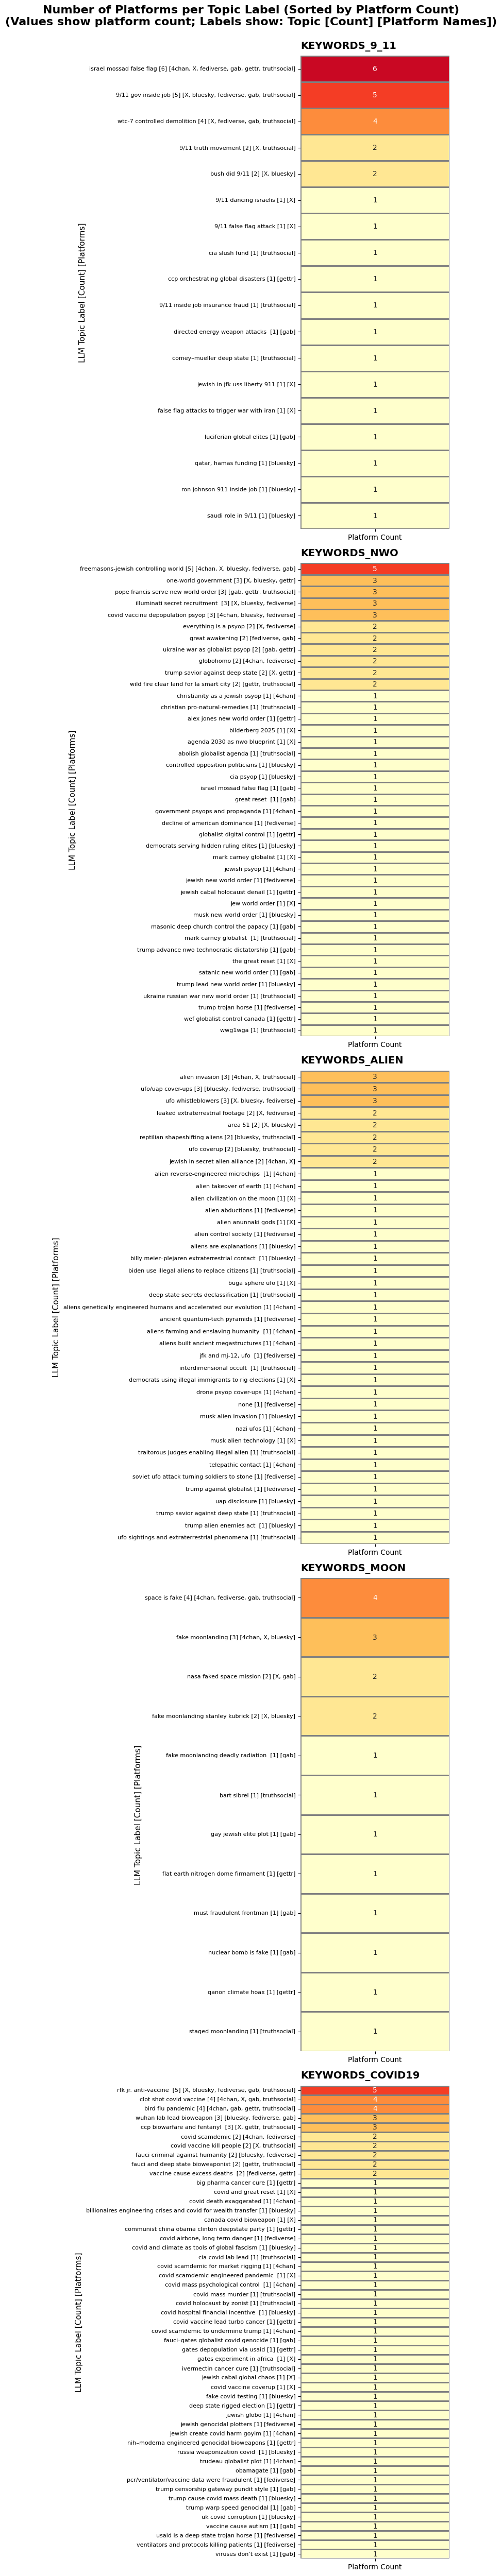

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get unique CT topics
ct_topics = df_results['topic'].unique()

# Create subplots - one per CT topic
fig, axes = plt.subplots(len(ct_topics), 1, figsize=(8, len(ct_topics)*max(10, len(ct_topics)*2)))

# Make axes iterable if only one topic
if len(ct_topics) == 1:
    axes = [axes]

for idx, ct_topic in enumerate(ct_topics):
    # Filter data for this CT topic
    topic_data = df_results[df_results['topic'] == ct_topic]
    
    # Count number of platforms per gpt_vali
    pivot_data = topic_data.groupby('gpt_vali')['platform'].nunique().to_frame()
    pivot_data.columns = ['num_platforms']
    
    # Get platform names for each gpt_vali
    platform_names = topic_data.groupby('gpt_vali')['platform'].apply(
        lambda x: ', '.join(sorted(x.unique()))
    )
    
    # Sort by platform count (descending), then alphabetically
    pivot_data = pivot_data.sort_values('num_platforms', ascending=False)
    platform_names = platform_names.loc[pivot_data.index]
    
    # Create extended labels with platform count and names
    extended_labels = []
    for label in pivot_data.index:
        count = pivot_data.loc[label, 'num_platforms']
        platforms = platform_names[label]
        extended_label = f"{label} [{count}] [{platforms}]"
        extended_labels.append(extended_label)
    
    # Reshape to single column for vertical heatmap
    heatmap_data = pivot_data[['num_platforms']].values
    
    # Create heatmap without colorbar
    ax = axes[idx]
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        cbar=False,  # Remove legend/colorbar
        linewidths=0.8,
        linecolor='gray',
        vmin=1,
        vmax=7,
        ax=ax,
        xticklabels=['Platform Count'],
        yticklabels=extended_labels
    )
    
    ax.set_title(f'{ct_topic}', fontsize=14, fontweight='bold', pad=10, loc='left')
    ax.set_xlabel('', fontsize=11)
    ax.set_ylabel('LLM Topic Label [Count] [Platforms]', fontsize=11)
    
    # Set x-axis label horizontal
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10, ha='center')
    
    # Set y-axis labels horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8, ha='right')

plt.suptitle('Number of Platforms per Topic Label (Sorted by Platform Count)\n(Values show platform count; Labels show: Topic [Count] [Platform Names])', 
             fontsize=16, fontweight='bold', y=0.9995)
plt.tight_layout()
plt.savefig("/VData/scro4316/ct_prevalence/bertopic_platforms_per_topic_label_heatmap.png", dpi=300)
plt.show()


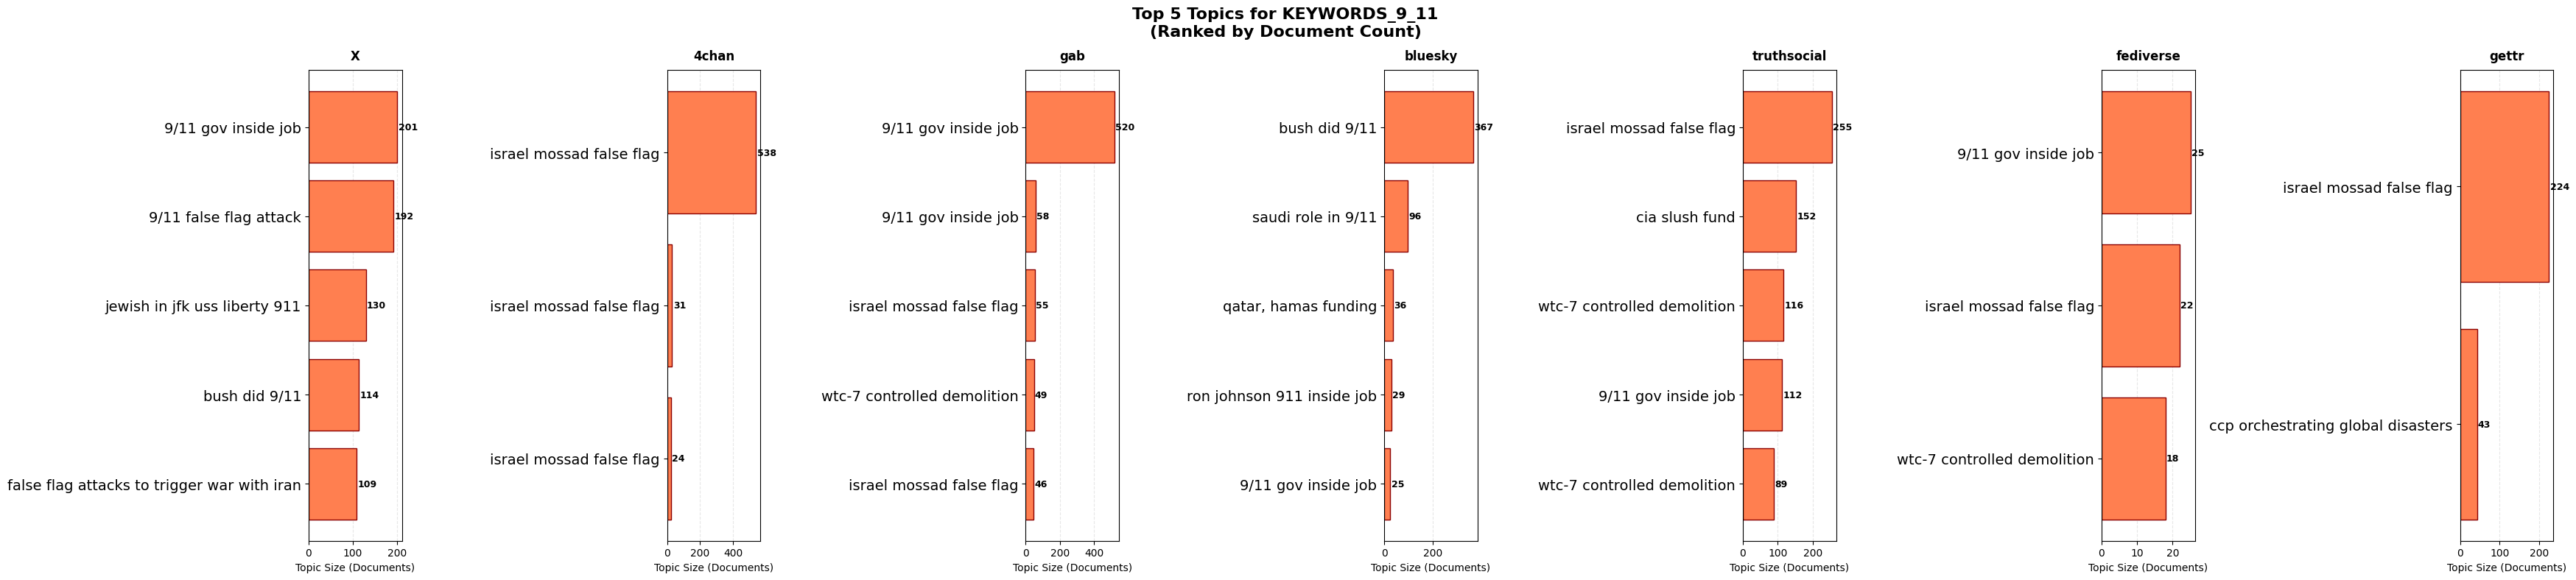

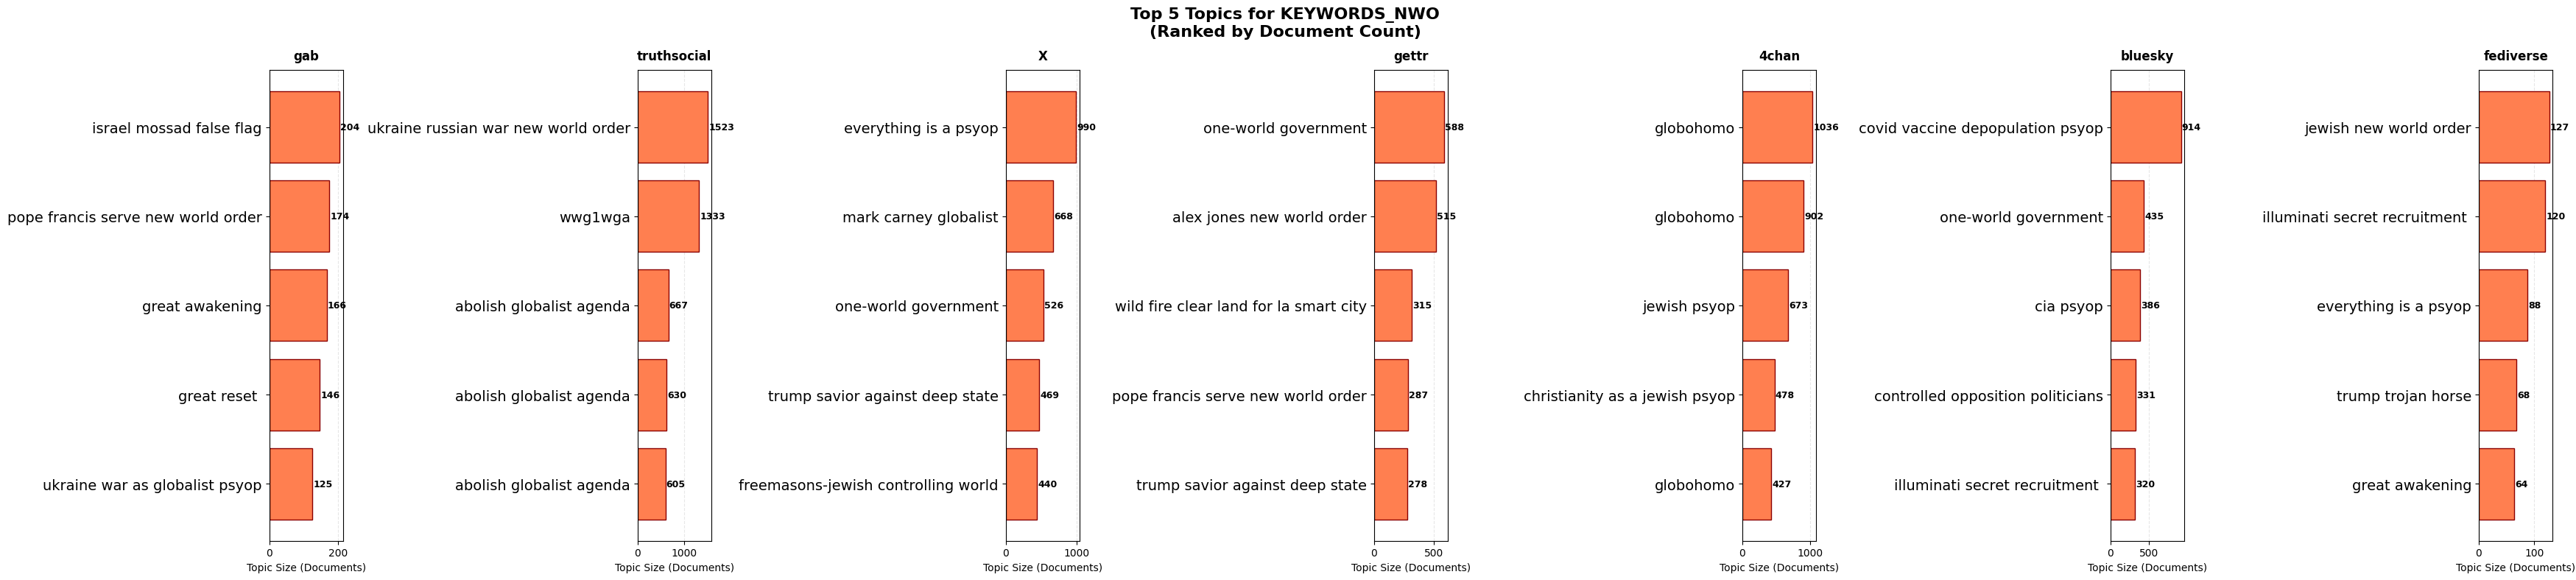

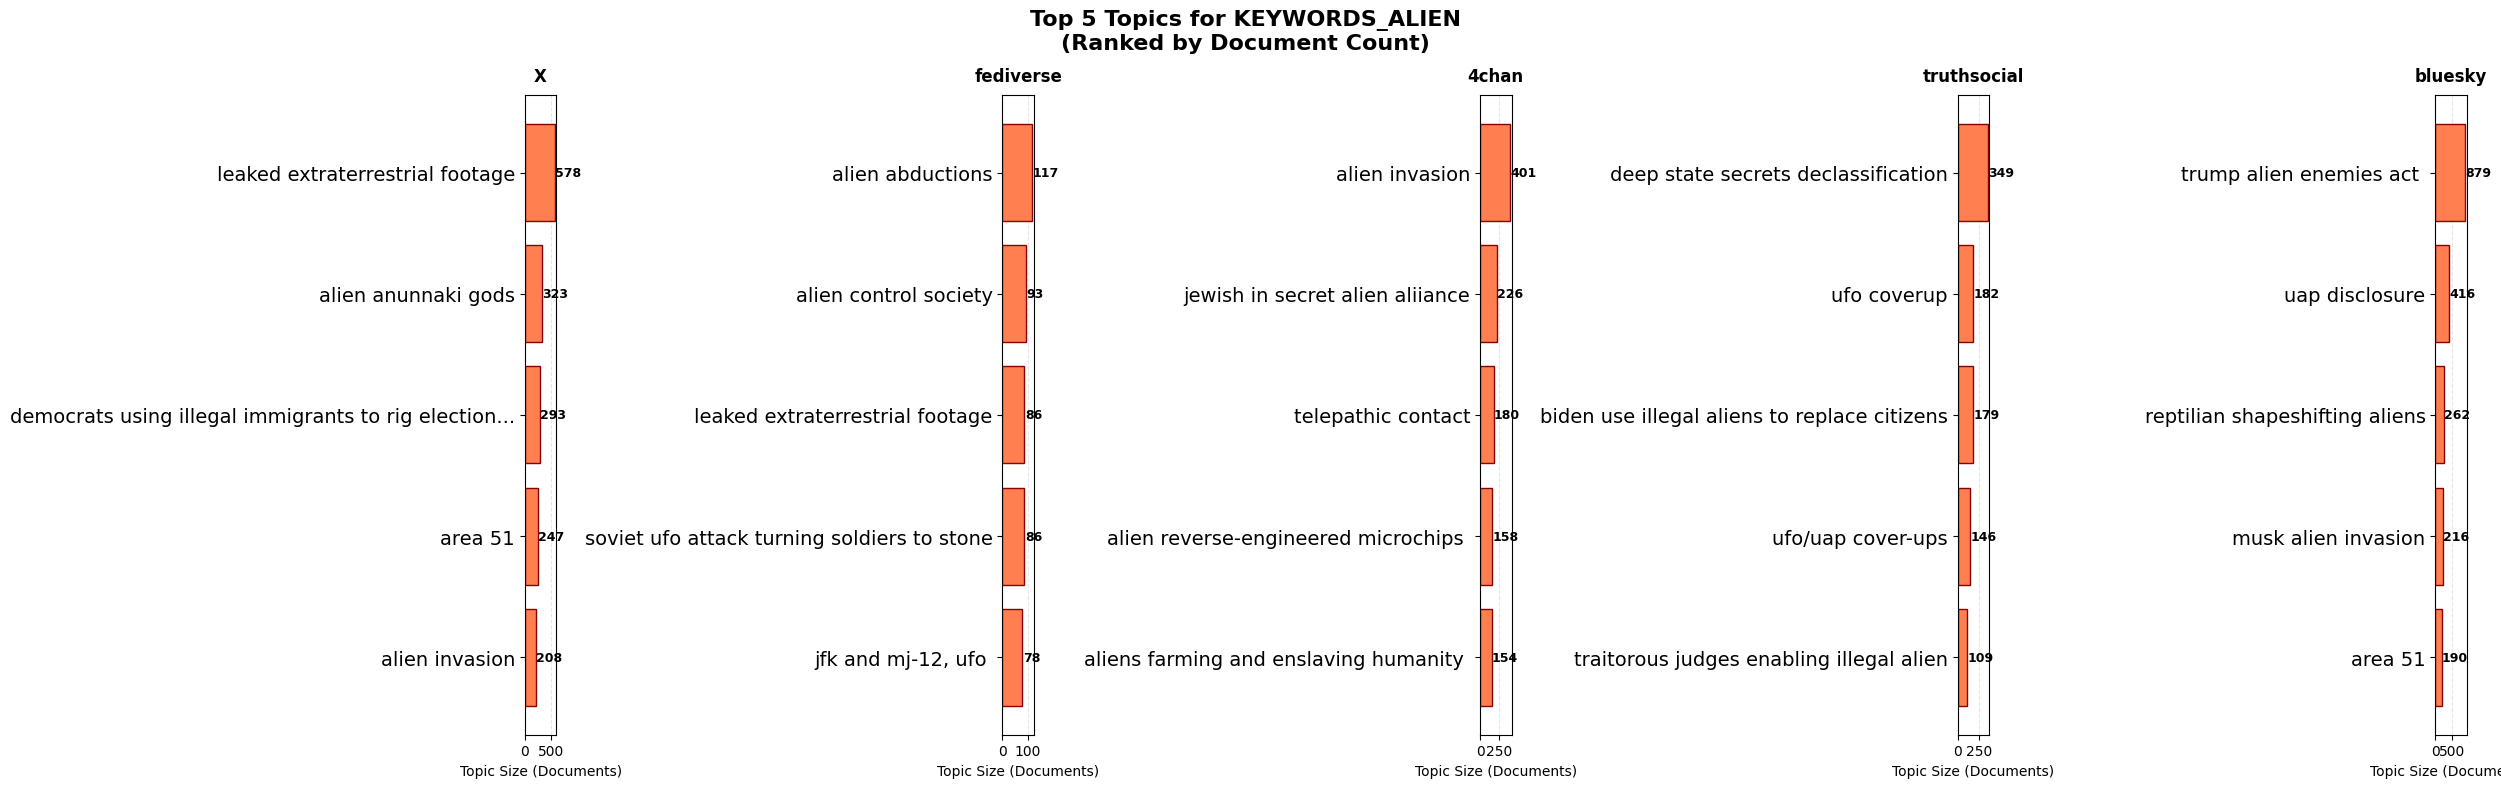

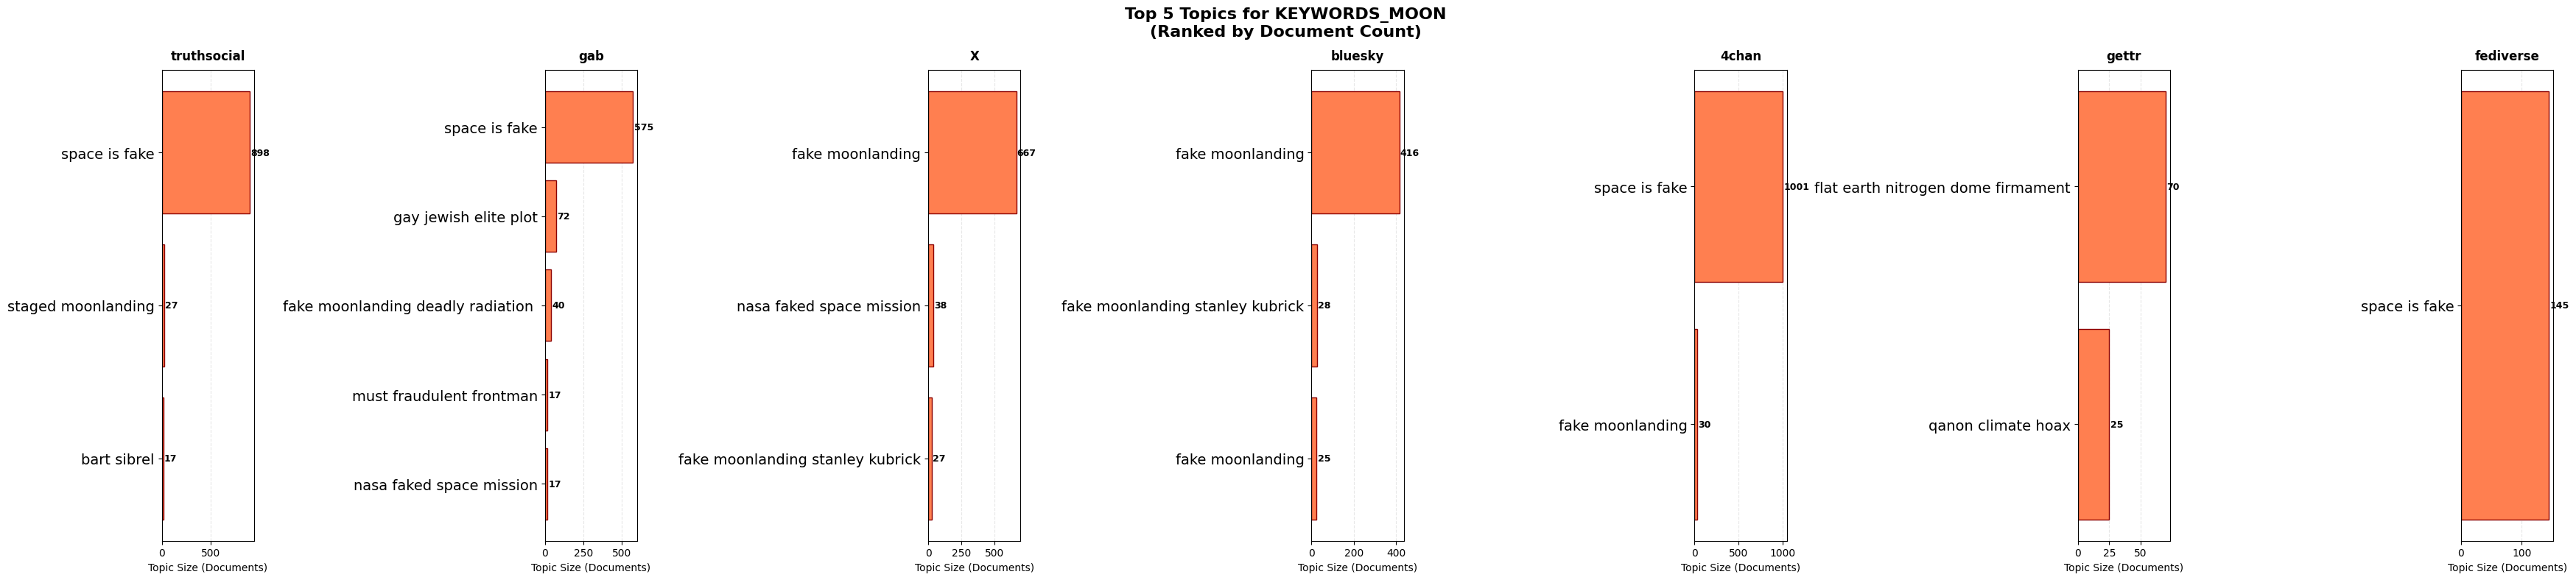

/tmp/ipykernel_407056/3529381715.py:61: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


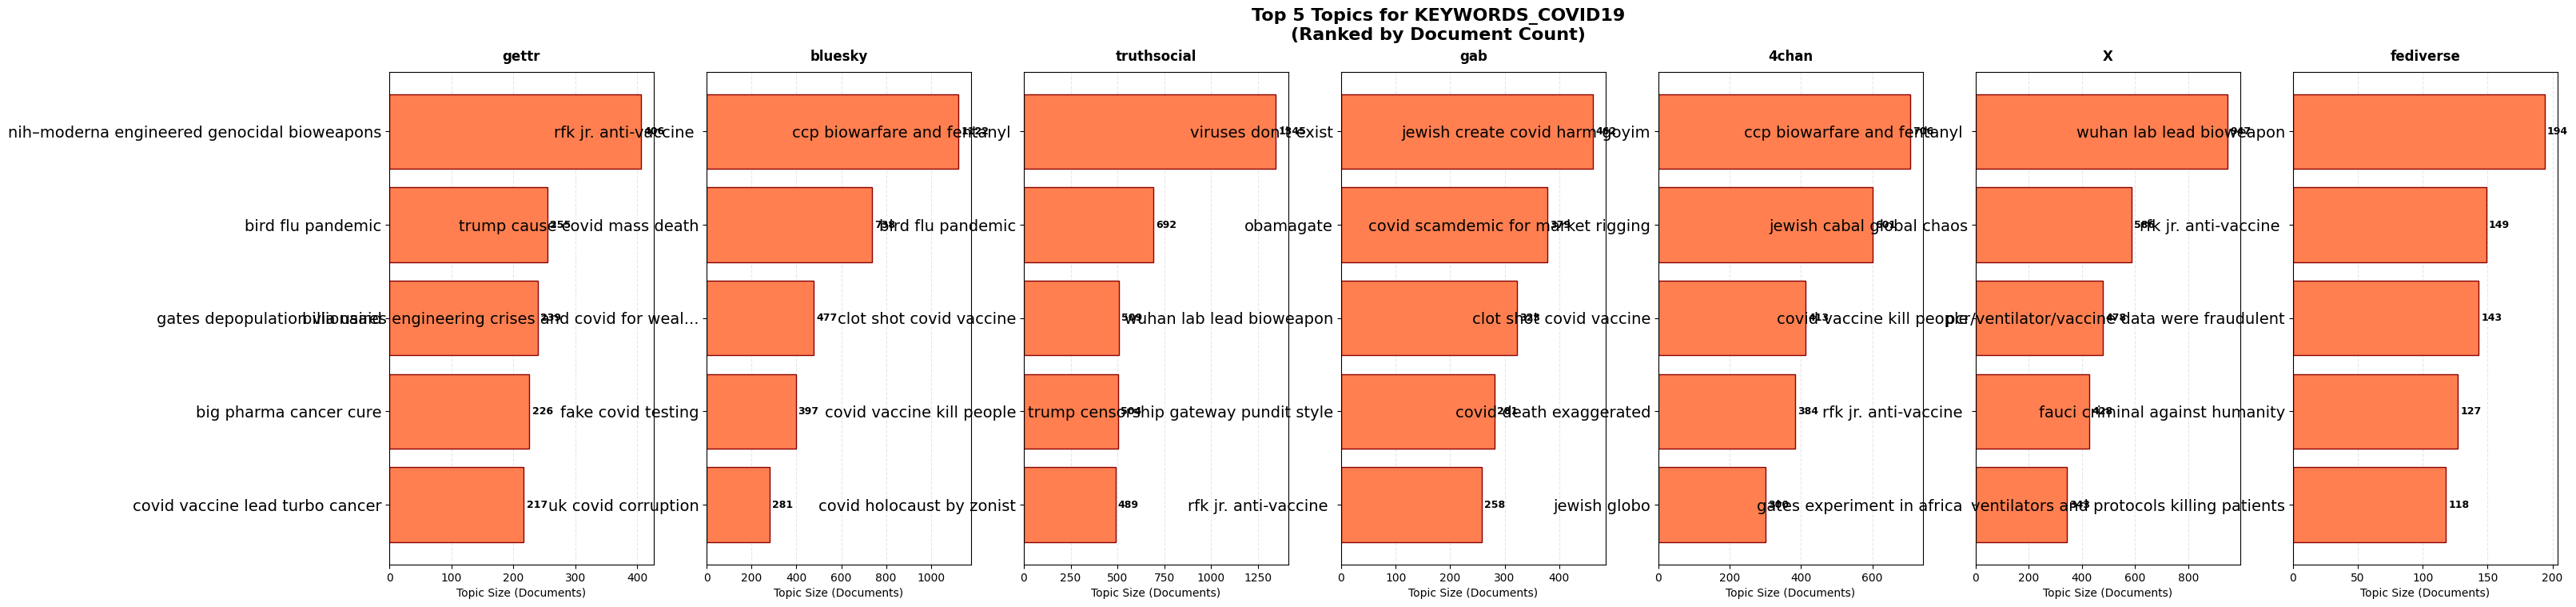

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get unique CT topics
ct_topics = df_results['topic'].unique()

# Create separate figure for each CT topic
for ct_topic in ct_topics:
    # Filter data for this CT topic
    ct_data = df_results[df_results['topic'] == ct_topic]
    platforms = ct_data['platform'].unique()
    
    # Create subplots - one per platform
    n_platforms = len(platforms)
    fig, axes = plt.subplots(1, n_platforms, figsize=(5*n_platforms, 8), squeeze=False)
    axes = axes[0]  # Flatten to 1D array
    
    for plat_idx, platform in enumerate(platforms):
        # Filter data for this platform
        platform_data = ct_data[ct_data['platform'] == platform]
        
        # Get top 5 topics by topic_size
        top5 = platform_data.nlargest(5, 'topic_size')[['gpt_vali', 'topic_size']]
        
        ax = axes[plat_idx]
        
        if len(top5) > 0:
            # Create horizontal bar chart
            y_pos = range(len(top5))
            bars = ax.barh(y_pos, top5['topic_size'].values, color='coral', edgecolor='darkred', linewidth=1)
            
            # Truncate labels if too long
            labels = [label[:50] + '...' if len(label) > 50 else label 
                     for label in top5['gpt_vali'].values]
            
            ax.set_yticks(y_pos)
            ax.set_yticklabels(labels, fontsize=14)
            ax.invert_yaxis()  # Rank 1 at top
            
            ax.set_xlabel('Topic Size (Documents)', fontsize=10)
            ax.set_title(f'{platform}', fontsize=12, fontweight='bold', pad=10)
            
            # Add value labels on bars
            for i, val in enumerate(top5['topic_size'].values):
                ax.text(val + max(top5['topic_size'])*0.01, i, f'{int(val)}', 
                       va='center', fontsize=9, fontweight='bold')
            
            ax.grid(axis='x', alpha=0.3, linestyle='--')
            ax.set_axisbelow(True)
        else:
            # No data
            ax.text(0.5, 0.5, 'No Data Available', 
                   ha='center', va='center', fontsize=12, color='gray',
                   transform=ax.transAxes)
            ax.set_title(f'{platform}', fontsize=12, fontweight='bold')
            ax.axis('off')
    
    fig.suptitle(f'Top 5 Topics for {ct_topic}\n(Ranked by Document Count)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()